# Objective

Train an image classifier that can detect different car body desgin types that are comonly seen on roads. A pre-trained *resnet* model is used for this purpose. The final model is intended to be deployed as a web application that anyone on the internet can easily interact with. A short online description of different body designs can be found here:<br> *https://www.motorist.sg/article/722/the-different-types-of-car-body-styles-explained/*

In [1]:
!pip install fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.6 MB/s eta 0:00:00 0:00:01


In [2]:
from fastbook import *

### Body Designs
The project is intended to differentiate between these 4 style designs: <u>*Van*</u> , <u>*Hatchback*</u> , <u>*Pickup Truck*</u> and <u>*Convertible*</u>. A short illustration of these four designs is shown below.

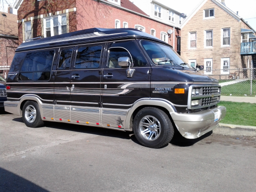

In [3]:
dest1 = "Van.jpg"
url1 = search_images_ddg('Van', 1)
download_url(url1[0], dest1)
Image.open(dest1).to_thumb(256)

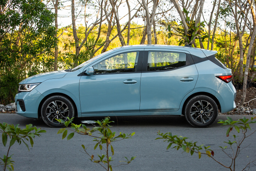

In [4]:
dest2 = "Hatchback.jpg"
url2 = search_images_ddg('hatchback', 1)
download_url(url2[0], dest2)
Image.open(dest2).to_thumb(256)

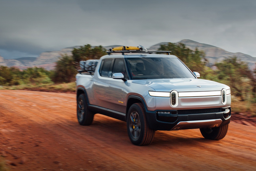

In [5]:
dest3 = "Pickup_Truck.jpg"
url3 = search_images_ddg('Pickup Truck', 1)
download_url(url3[0], dest3)
Image.open(dest3).to_thumb(256)

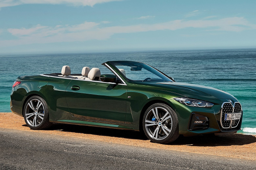

In [6]:
dest4 = "Convertible.jpg"
url4 = search_images_ddg('Convertible', 1)
download_url(url4[0], dest4)
Image.open(dest4).to_thumb(256)

### Creating Dataset: *duckduckgo image search api*
Around 200 images per car design style is stored in the dataset.

In [7]:
styles = ["Van", "Hatchback", "Pickup_Truck", "Convertible"]
path = Path('Design')

if not path.exists():
    path.mkdir()
    for o in styles:
        dest = (path/o)
        dest.mkdir(exist_ok = True)
        results = search_images_ddg(o)
        download_images(dest = dest, urls = results)

In [8]:
# List of images in path
fns = get_image_files(path)
fns

(#715) [Path('Design/Pickup_Truck/97731d52-909a-41bd-b6f0-e50e10feefa4.jpg'),Path('Design/Pickup_Truck/c59be5ce-7ba3-4168-a65d-df464b247512.jpg'),Path('Design/Pickup_Truck/535398ac-77cb-4394-9494-3c2b099d80b2.jpg'),Path('Design/Pickup_Truck/ab0a64e6-2c12-4719-95b0-a85a09ff71a2.jpg'),Path('Design/Pickup_Truck/6be29c79-f489-4b5f-a436-a4e0eedb77e2.png'),Path('Design/Pickup_Truck/9fcd3c58-7d55-4674-a639-2f25e0c736a5.jpg'),Path('Design/Pickup_Truck/7aa5373a-0dc5-4743-b495-b864a26831be.jpg'),Path('Design/Pickup_Truck/41a5196a-a04e-40c7-9678-33d02ec06e05.jpeg'),Path('Design/Pickup_Truck/76576c0a-3a5a-4e79-a1db-8db0940e4041.jpg'),Path('Design/Pickup_Truck/fedc082d-5e80-42d1-bcd9-5506ea2353c6.jpg')...]

In [9]:
# Looking for corrupt images
failed = verify_images(fns)
failed

(#58) [Path('Design/Pickup_Truck/7aa5373a-0dc5-4743-b495-b864a26831be.jpg'),Path('Design/Pickup_Truck/b2bde26f-b1f6-4744-870d-7d71f65e014b.jpg'),Path('Design/Pickup_Truck/d1fd26a6-e4e3-46f5-8aaf-af774ea4271d.jpg'),Path('Design/Pickup_Truck/4f178251-b061-4607-86ec-cea1b3966a73.jpg'),Path('Design/Pickup_Truck/61978591-2fac-4b43-8899-ccc06aac34b0.jpg'),Path('Design/Pickup_Truck/9ae4da60-b0ef-4040-afac-62622bf21647.jpg'),Path('Design/Pickup_Truck/873beccb-8918-4e58-a0bf-94d40c296148.jpg'),Path('Design/Pickup_Truck/f6073774-94f7-4a9d-8771-5ac698a983ff.jpg'),Path('Design/Pickup_Truck/146e7846-9d64-474b-b1c2-2ef739b91226.jpg'),Path('Design/Pickup_Truck/702fdf38-73e7-49f5-b886-07e731e14ea9.jpg')...]

In [10]:
print(f"So we are having {len(failed)} corrupt images in our dataset, which we'll need to correct.")

So we are having 58 corrupt images in our dataset, which we'll need to correct.


In [11]:
# .map is an iterator running over the list 'failed'
failed.map(Path.unlink)

(#58) [None,None,None,None,None,None,None,None,None,None...]

In [12]:
# Corrupt images have been removed
fns = get_image_files(path)
verify_images(fns)

(#0) []

In [13]:
# Using datablock API to create dataloaders

car = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label,
    item_tfms=RandomResizedCrop(256, min_scale=0.5),
    batch_tfms=aug_transforms()
)

A higher *min_scale* value is typically required when **context** in an image is important. Here, some context is required. This is because body designs such as **Van** and **Hatchback** can be similar and might require more information to create meaningful convolutional features. This is why an intermediate value of *min_scale* is chosen.

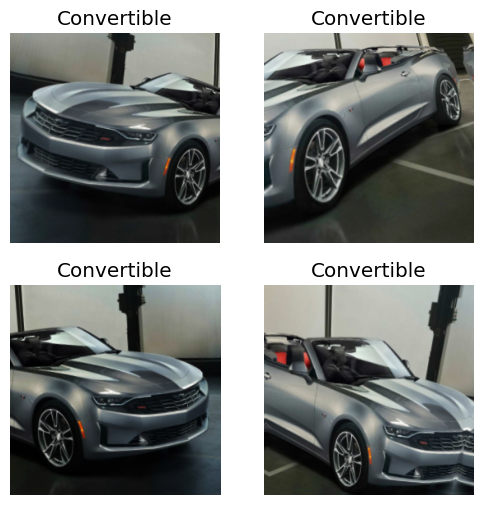

In [14]:
# Creating a dataloaders object
dls = car.dataloaders(path)

# Different augmentations of the same image
dls.show_batch(max_n=4, unique=True)

### Basic learner for data cleaning
At first, a basic learner (resnet architecture with 18 layers) is trained for less number of epochs to determine how the training process is behaving. This learner is also used for data cleaning. After these steps are carried out, a final learner (same architecture and depth) is created which is trained for more number of epochs for greater accuracy.

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.835522,0.633498,0.236641,00:17


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.786716,0.335472,0.106870,00:16
1,0.627696,0.238621,0.061069,00:17
2,0.482217,0.277523,0.061069,00:17
3,0.420846,0.296734,0.076336,00:17


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


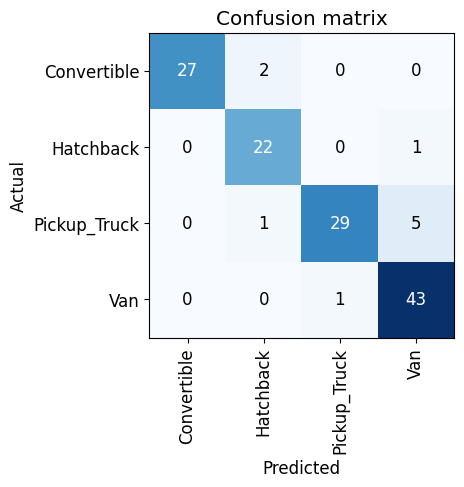

In [17]:
# Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn) 
interp.plot_confusion_matrix()

The model is already performing well! We can now identify which images in the training data have the highest losses.

In [19]:
# We can now manage those images having the highest loss
# This is a more efficient way of data cleaning

from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn) 
cleaner

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [20]:
# Performing data cleaning
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [21]:
# Recreating dataloaders

car = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label,
    item_tfms=RandomResizedCrop(256, min_scale=0.6),
    batch_tfms=aug_transforms(mult=1.2)
)

dls = car.dataloaders(path)

In [22]:
# Retraining the model with cleaner data
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(9)

epoch,train_loss,valid_loss,error_rate,time
0,1.943603,0.576639,0.229008,00:17


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.795421,0.291837,0.099237,00:17
1,0.692560,0.207509,0.068702,00:18
2,0.556528,0.207292,0.083969,00:18
3,0.452870,0.245776,0.083969,00:17
4,0.369773,0.243981,0.076336,00:18
5,0.307084,0.221273,0.068702,00:17
6,0.271627,0.217281,0.068702,00:18
7,0.233280,0.213404,0.068702,00:17
8,0.205503,0.211769,0.061069,00:17


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes sh

The created model has an accuracy >99% on the validation set.

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


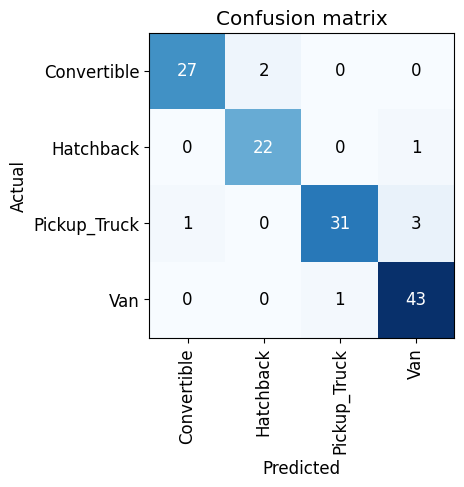

In [23]:
# The accuracy has considerably improved 

interp = ClassificationInterpretation.from_learner(learn) 
interp.plot_confusion_matrix()

The prediction for *Pickup Truck* has slightly improved compared to the previous model. This is also seen in higher accuracy of the new model.

In [24]:
# Exporting the model created

learn.export('bd_design.pkl')

In [25]:
# Exported model is saved 

path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('bd_design.pkl')]

### Conclusion
This notebook shows how the model is created. This model is exported and will be used to *detect* the body design of any uploaded car image. This model can only detect these four designs: <u>*Van, Hatchback, Pickup Truck and Convertible.*</u><br>

However for any car that doesn't fit into any of these 4 categories, this model is capable of recognising which design is most similar to the actual design for any randomly uploaded car image.